
# Semana 5 — Projeto de Análise dos Gastos Pessoais 💰📊

Este notebook carrega o arquivo **`gastos_estudo_clean.csv`**, faz uma análise exploratória (EDA), gera gráficos, produz **insights automáticos** e cria uma **projeção simples** de gastos.

> Dica: deixe o CSV na mesma pasta do notebook. Se preferir, ajuste o caminho em `DATA_PATH`.


In [10]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from typing import Tuple, Dict

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# config de exibição
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X",".") )

# caminho do CSV
DATA_PATH = "gastos_estudo_clean.csv"

# fallback para o arquivo salvo na sessão (se existir)
if not os.path.exists(DATA_PATH):
    alt = "data/semana5_prática_revisão/gastos_estudo_clean.csv"
    if os.path.exists(alt):
        DATA_PATH = alt

DATA_PATH


'gastos_estudo_clean.csv'

## 1) Carregar dados

In [11]:

df = pd.read_csv(DATA_PATH, encoding="utf-8")
# Normaliza nomes esperados caso venham diferentes
def norm(s): 
    return (s.strip().lower().replace(" ", "_")
            .replace("(", "").replace(")", "")
            .replace("ç","c").replace("ã","a").replace("á","a")
            .replace("é","e").replace("í","i").replace("ó","o")
            .replace("ú","u").replace("â","a").replace("ê","e")
            .replace("ô","o").replace("à","a").replace("ü","u"))

df.columns = [norm(c) for c in df.columns]

# Mapear colunas mais prováveis
date_col = next((c for c in df.columns if c in ["data","date","timestamp","data_compra","data_lancamento"]), None)
value_col = next((c for c in df.columns if c in ["valor_(r$)","valor","valor (r$)","valor_r$","amount","preco","price","gasto"]), None)
cat_col   = next((c for c in df.columns if c in ["categoria","classificacao","classe","category"]), None)
desc_col  = next((c for c in df.columns if c in ["descricao","descricao_compra","memo","observacao","description"]), None)
pay_col   = next((c for c in df.columns if c in ["forma_pagamento","forma_de_pagamento","metodo_pagamento","payment_method","pagamento"]), None)

# Parse de data e valor
if date_col is None or value_col is None:
    raise ValueError("Não encontrei colunas de Data e/ou Valor no CSV. Verifique nomes.")

df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
if df[value_col].dtype == object:
    df[value_col] = (df[value_col].astype(str)
                     .str.replace(".", "", regex=False)
                     .str.replace(",", ".", regex=False))
df[value_col] = pd.to_numeric(df[value_col], errors="coerce")

# Drop linhas sem data/valor
df = df.dropna(subset=[date_col, value_col]).copy()

# Colunas derivadas
df["ano"] = df[date_col].dt.year
df["mes"] = df[date_col].dt.month
df["dia"] = df[date_col].dt.day
df["ym"] = df[date_col].dt.to_period("M").astype(str)

print("Linhas:", len(df))
df.head()


Linhas: 37


,data,categoria,descricao,valor_r$,forma_pagamento,tipo,ano,mes,dia,ym
0,2025-08-07,Presente,Mercado Livre,"145,90",Cartão Crédito,Variável,2025,8,7,2025-08
1,2025-08-08,Assinatura,Spotify,"34,90",Cartão Crédito,Fixo,2025,8,8,2025-08
2,2025-08-08,Suplemento,Mercado Livre,"99,90",Cartão Crédito,Variável,2025,8,8,2025-08
3,2025-08-08,Compras,Mercado Livre,"62,70",Cartão Crédito,Variável,2025,8,8,2025-08
4,2025-08-13,Assinatura,Apple,"9,99",Cartão Crédito,Fixo,2025,8,13,2025-08


## 2) Análise descritiva

In [12]:

total = df[value_col].sum()
qtd = df[value_col].count()
media = df[value_col].mean()
mediana = df[value_col].median()
vmin, vmax = df[value_col].min(), df[value_col].max()

resumo = pd.DataFrame([{
    "Total (R$)": total,
    "Qtd transações": qtd,
    "Média (R$)": media,
    "Mediana (R$)": mediana,
    "Mínimo (R$)": vmin,
    "Máximo (R$)": vmax
}])

resumo


,Total (R$),Qtd transações,Média (R$),Mediana (R$),Mínimo (R$),Máximo (R$)
0,"6.761,10",37,"182,73","59,90","5,90","2.349,53"


### 2.1) Série temporal — gasto por dia

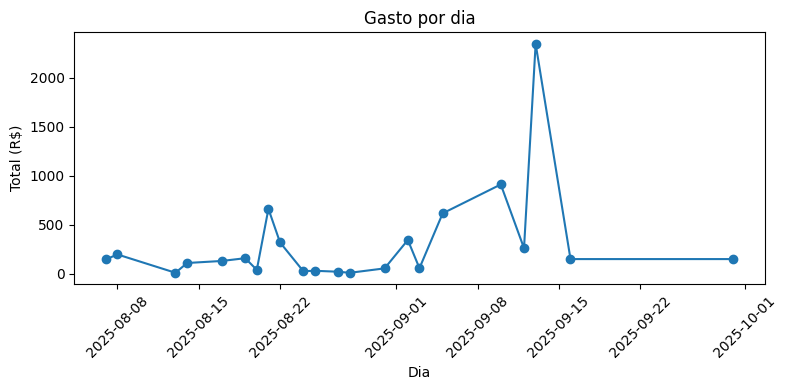

,data,valor_r$
17,2025-09-10,"912,32"
18,2025-09-12,"260,98"
19,2025-09-13,"2.349,53"
20,2025-09-16,"150,00"
21,2025-09-30,"150,00"


In [13]:

daily = df.groupby(df[date_col].dt.date)[value_col].sum().reset_index()
plt.figure(figsize=(8,4))
plt.plot(daily[date_col], daily[value_col], marker='o')
plt.xticks(rotation=45)
plt.xlabel("Dia"); plt.ylabel("Total (R$)"); plt.title("Gasto por dia")
plt.tight_layout(); plt.show()

daily.tail()


### 2.2) Ranking de categorias

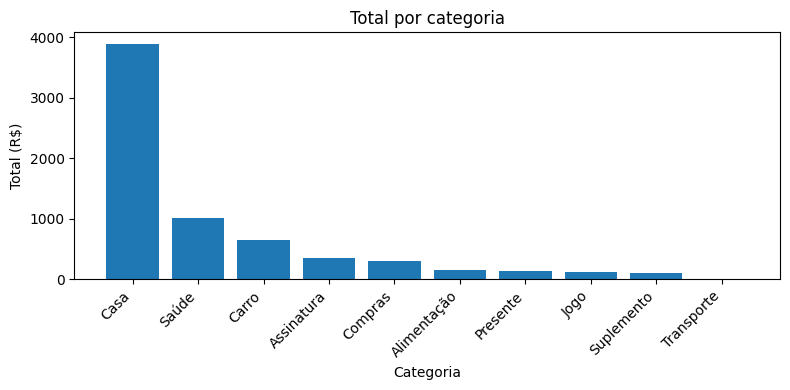

In [14]:

if cat_col is not None and cat_col in df.columns:
    by_cat = df.groupby(cat_col)[value_col].sum().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(8,4))
    plt.bar(by_cat[cat_col].astype(str), by_cat[value_col])
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Categoria"); plt.ylabel("Total (R$)"); plt.title("Total por categoria")
    plt.tight_layout(); plt.show()
    by_cat.head(10)
else:
    print("Sem coluna de categoria no CSV — pulando este passo.")


### 2.3) Total por forma de pagamento

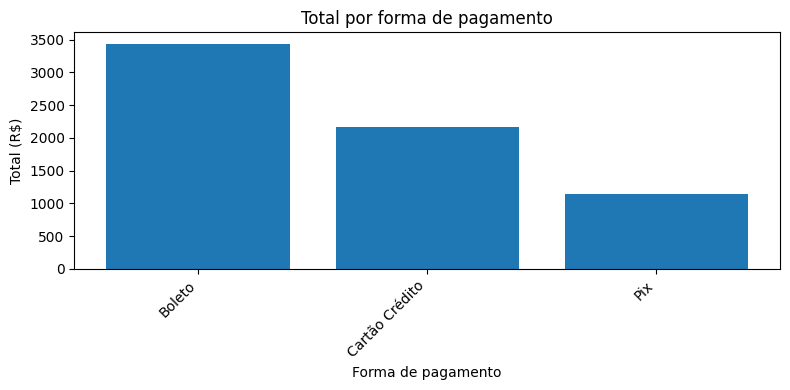

In [15]:

if pay_col is not None and pay_col in df.columns:
    by_pay = df.groupby(pay_col)[value_col].sum().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(8,4))
    plt.bar(by_pay[pay_col].astype(str), by_pay[value_col])
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Forma de pagamento"); plt.ylabel("Total (R$)"); plt.title("Total por forma de pagamento")
    plt.tight_layout(); plt.show()
    by_pay
else:
    print("Sem coluna de forma de pagamento no CSV — pulando este passo.")


## 3) Insights automáticos

In [16]:

insights = []

# 1) Maior categoria e participação (%)
if cat_col is not None and cat_col in df.columns:
    by_cat = df.groupby(cat_col)[value_col].sum().sort_values(ascending=False)
    top_cat = by_cat.index[0]
    top_val = by_cat.iloc[0]
    share = top_val / df[value_col].sum()
    insights.append(f"Categoria de maior gasto: **{top_cat}** (R$ {top_val:,.2f}) — {share:.1%} do total.")

# 2) Dia de maior gasto
daily = df.groupby(df[date_col].dt.date)[value_col].sum()
dia_max = daily.idxmax()
val_max = daily.max()
insights.append(f"Dia com maior gasto: **{dia_max}** (R$ {val_max:,.2f}).")

# 3) Outliers por IQR
q1, q3 = df[value_col].quantile(0.25), df[value_col].quantile(0.75)
iqr = q3 - q1
limite = q3 + 1.5 * iqr
outliers = df[df[value_col] > limite]
if not outliers.empty:
    insights.append(f"Foram encontrados **{len(outliers)}** gastos considerados outliers (>{limite:,.2f}).")
else:
    insights.append("Não foram detectados outliers relevantes pelo critério IQR.")

print("\n".join(insights))
outliers.sort_values(value_col, ascending=False).head(10)


Categoria de maior gasto: **Casa** (R$ 3,890.11) — 57.5% do total.
Dia com maior gasto: **2025-09-13** (R$ 2,349.53).
Foram encontrados **4** gastos considerados outliers (>324.40).


,data,categoria,descricao,valor_r$,forma_pagamento,tipo,ano,mes,dia,ym
32,2025-09-13,Casa,Apto,"2.349,53",Boleto,Fixo,2025,9,13,2025-09
33,2025-09-10,Saúde,Academia,"700,00",Pix,Essencial,2025,9,10,2025-09
14,2025-08-21,Carro,Revisão carro,"653,00",Cartão Crédito,Essencial,2025,8,21,2025-08
29,2025-09-05,Casa,Condomínio,"617,28",Boleto,Fixo,2025,9,5,2025-09


## 4) Projeção simples de gasto (regressão linear)

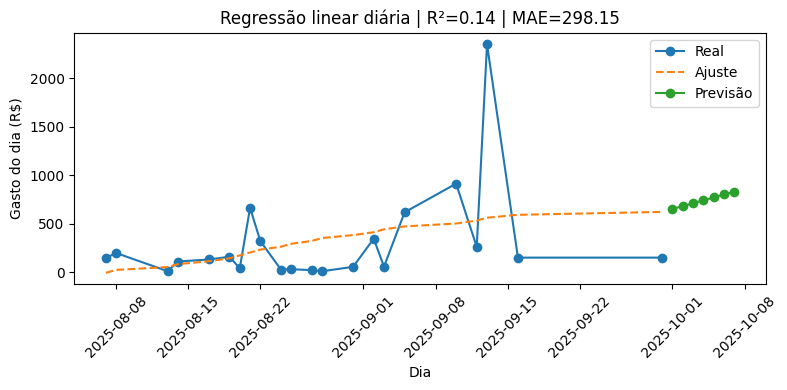

In [17]:

# Estratégia: usar série diária acumulada ou mensal. Se há apenas um mês, fazemos linha no tempo diária.
ts = df.groupby(df[date_col].dt.to_period('D'))[value_col].sum().to_timestamp().sort_index()

if len(ts) >= 7:
    # Regressão linear nos dias (X = ordinal do dia, y = gasto do dia)
    X = np.arange(len(ts)).reshape(-1,1)
    y = ts.values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    # previsão para os próximos 7 dias
    fut_h = 7
    X_future = np.arange(len(ts), len(ts)+fut_h).reshape(-1,1)
    y_future = model.predict(X_future)

    # plot
    plt.figure(figsize=(8,4))
    plt.plot(ts.index, y, marker='o', label="Real")
    plt.plot(ts.index, y_pred, linestyle='--', label="Ajuste")
    future_idx = pd.date_range(ts.index[-1] + pd.Timedelta(days=1), periods=fut_h, freq='D')
    plt.plot(future_idx, y_future, marker='o', label="Previsão")
    plt.xticks(rotation=45)
    plt.title(f"Regressão linear diária | R²={r2:.2f} | MAE={mae:,.2f}")
    plt.xlabel("Dia"); plt.ylabel("Gasto do dia (R$)")
    plt.legend()
    plt.tight_layout(); plt.show()

    pd.DataFrame({"data": future_idx, "previsao_gasto_dia_R$": y_future})
else:
    print("Série muito curta para projeção confiável (menos de 7 pontos). Adicione mais dias/meses para melhorar o ajuste.")



## 5) Conclusões
- Revise os **insights automáticos** e verifique se fazem sentido no seu contexto.
- Ajuste categorias/limpezas no CSV se notar inconsistências.
- Se quiser um modelo mais robusto de previsão, acumule **mais meses** e troque a regressão diária por uma **mensal**.
